## Valorant Volatility Straddle: Exit Threshold Analysis

This notebook implements the analysis described in `Valorant Exit Threshold Math and Plan.md`:

- **Pull and load historical market data**
- **Inspect and clean the dataset**
- **Define favorite / cheap side over time**
- **Extract “hit events” at price levels**
- **Estimate conditional win probabilities and EV by threshold**

We will work step by step, keeping the logic transparent and reproducible.


In [29]:
# Imports and configuration

import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")

# Project paths
PROJECT_ROOT = Path("/Users/boio/Polymarket")
DATA_DIR = PROJECT_ROOT / "Strategy 2" / "Threshold Calculation" / "Pulled Data"

# Main enriched pipeline output (current working file)
ENRICHED_CSV = DATA_DIR / "valorant_pipeline_output_enriched.csv"

ENRICHED_CSV


PosixPath('/Users/boio/Polymarket/Strategy 2/Threshold Calculation/Pulled Data/valorant_pipeline_output_enriched.csv')

### 1. Load raw enriched data

We start by loading `valorant_pipeline_output_enriched.csv`, which currently has columns like:

- `market_id`
- `ts`
- `price_team_a`, `price_team_b`
- `final_winner`
- `team_a_name`, `team_b_name`
- `winner_side`, `winner_team_name`

We will inspect basic structure, dtypes, and a few sample rows.


In [30]:
# Load enriched CSV

assert ENRICHED_CSV.exists(), f"File not found: {ENRICHED_CSV}"

raw_df = pd.read_csv(ENRICHED_CSV)

print("Shape:", raw_df.shape)
print("\nDtypes:\n", raw_df.dtypes)
print(raw_df["market_id"].nunique())

raw_df.head()


Shape: (182740, 9)

Dtypes:
 market_id             int64
ts                   object
price_team_a        float64
price_team_b        float64
final_winner         object
team_a_name          object
team_b_name          object
winner_side          object
winner_team_name     object
dtype: object
141


,market_id,ts,price_team_a,price_team_b,final_winner,team_a_name,team_b_name,winner_side,winner_team_name
0,667567,2025-11-06T13:20:07+00:00,NaN,0.5,A,Team Envy,Cloud9,A,Team Envy
1,667567,2025-11-06T13:20:08+00:00,0.5,0.5,A,Team Envy,Cloud9,A,Team Envy
2,667567,2025-11-06T13:30:12+00:00,0.5,0.5,A,Team Envy,Cloud9,A,Team Envy
3,667567,2025-11-06T13:30:14+00:00,0.5,0.5,A,Team Envy,Cloud9,A,Team Envy
4,667567,2025-11-06T13:40:07+00:00,0.5,0.5,A,Team Envy,Cloud9,A,Team Envy


### 2. Basic cleaning and type handling

In this section we:

- Parse `ts` as a proper datetime
- Ensure prices are numeric in \([0, 1]\)
- Drop obviously bad rows (missing `market_id`, `final_winner`, or both prices)

We keep this cleaning **lightweight** so that downstream math uses a clear, well-defined subset of the data.


In [31]:
# Light cleaning

df = raw_df.copy()

# Parse timestamp
if 'ts' in df.columns:
    df['ts'] = pd.to_datetime(df['ts'], errors='coerce')

# Coerce prices to numeric
for col in ['price_team_a', 'price_team_b']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing essentials
required_cols = ['market_id', 'price_team_a', 'price_team_b', 'final_winner']
missing_required = [c for c in required_cols if c not in df.columns]
if missing_required:
    print("Warning: missing expected columns:", missing_required)

present_required = [c for c in required_cols if c in df.columns]
df = df.dropna(subset=present_required)

# Basic sanity filter on prices (optional)
for col in ['price_team_a', 'price_team_b']:
    if col in df.columns:
        df = df[(df[col] >= 0.0) & (df[col] <= 1.0)]

print("After cleaning:", df.shape)
df.head()


After cleaning: (182625, 9)


,market_id,ts,price_team_a,price_team_b,final_winner,team_a_name,team_b_name,winner_side,winner_team_name
1,667567,2025-11-06 13:20:08+00:00,0.5,0.5,A,Team Envy,Cloud9,A,Team Envy
2,667567,2025-11-06 13:30:12+00:00,0.5,0.5,A,Team Envy,Cloud9,A,Team Envy
3,667567,2025-11-06 13:30:14+00:00,0.5,0.5,A,Team Envy,Cloud9,A,Team Envy
4,667567,2025-11-06 13:40:07+00:00,0.5,0.5,A,Team Envy,Cloud9,A,Team Envy
5,667567,2025-11-06 13:40:08+00:00,0.5,0.5,A,Team Envy,Cloud9,A,Team Envy


### 3. Define favorite and cheap side over time

Following the plan document, for each snapshot we:

- Identify the **favorite**: higher implied probability (higher price)
- Identify the **cheap side**: lower implied probability (lower price)
- Record:
  - `price_fav`, `price_cheap`
  - `favorite_side` (A/B)
  - `final_fav_won` (1 if favorite ultimately won, 0 otherwise)

This gives us the key variables used later to define hit events and estimate \( q(p_c) \).


In [32]:
# Derive favorite / cheap side columns

side_cols_present = all(c in df.columns for c in ['price_team_a', 'price_team_b'])
if not side_cols_present:
    raise ValueError("Expected price_team_a and price_team_b columns to define favorite/cheap.")

# Favorite is the side with higher price; cheap is lower
fav_is_a = df['price_team_a'] >= df['price_team_b']

df['price_fav'] = np.where(fav_is_a, df['price_team_a'], df['price_team_b'])
df['price_cheap'] = np.where(fav_is_a, df['price_team_b'], df['price_team_a'])
df['favorite_side'] = np.where(fav_is_a, 'A', 'B')

# Map final_winner into "did favorite win?"
# Assumes final_winner encodes side (e.g. 'A'/'B' or 0/1 aligned with A/B)

if df['final_winner'].dtype == object:
    df['final_fav_won'] = (df['final_winner'] == df['favorite_side']).astype(int)
else:
    # If encoded numerically, assume 0 -> A, 1 -> B (adjust if your encoding differs)
    winner_side_num = df['final_winner'].astype(int)
    fav_side_num = np.where(fav_is_a, 0, 1)
    df['final_fav_won'] = (winner_side_num == fav_side_num).astype(int)

df[['market_id', 'ts', 'price_team_a', 'price_team_b', 'price_fav', 'price_cheap', 'favorite_side', 'final_fav_won']].sort_values("price_cheap", ascending=True).head()


,market_id,ts,price_team_a,price_team_b,price_fav,price_cheap,favorite_side,final_fav_won
182739,754326,2025-11-30 13:40:08+00:00,0.9995,0.0005,0.9995,0.0005,A,1
108034,679782,2025-11-24 19:50:21+00:00,0.0005,0.9995,0.9995,0.0005,B,1
108035,679782,2025-11-24 19:50:24+00:00,0.0005,0.9995,0.9995,0.0005,B,1
108036,679782,2025-11-24 20:00:10+00:00,0.0005,0.9995,0.9995,0.0005,B,1
108037,679782,2025-11-24 20:00:13+00:00,0.0005,0.9995,0.9995,0.0005,B,1


In [ ]:
# Filter to markets that were at 50-50 (within 2% deviation) at some point
# Entry condition: prices must have been between 0.48 and 0.52 at some snapshot

ENTRY_DEVIATION = 0.02  # 2% deviation
ENTRY_MIN = 0.5 - ENTRY_DEVIATION  # 0.48
ENTRY_MAX = 0.5 + ENTRY_DEVIATION  # 0.52

print(f"Entry condition: prices between {ENTRY_MIN:.2f} and {ENTRY_MAX:.2f}")

# For each market, check if any snapshot has prices near 50-50
# We check both price_team_a and price_team_b (either side can be near 0.5)
markets_with_entry = df.groupby('market_id').apply(
    lambda g: (
        (g['price_team_a'].between(ENTRY_MIN, ENTRY_MAX)).any() |
        (g['price_team_b'].between(ENTRY_MIN, ENTRY_MAX)).any()
    )
).reset_index(name='has_entry_opportunity')

valid_market_ids = markets_with_entry[markets_with_entry['has_entry_opportunity']]['market_id'].values

print(f"\nBefore filtering: {df['market_id'].nunique()} markets")
df = df[df['market_id'].isin(valid_market_ids)].copy()
print(f"After filtering: {df['market_id'].nunique()} markets")
print(f"Rows remaining: {len(df)}")

# Show some examples of markets that passed the filter
if len(df) > 0:
    sample_market = df['market_id'].iloc[0]
    sample_data = df[df['market_id'] == sample_market].sort_values('ts').head(10)
    print(f"\nSample market {sample_market} (first 10 snapshots):")
    print(sample_data[['market_id', 'ts', 'price_team_a', 'price_team_b', 'price_cheap']].to_string(index=False))


### 4. Event extraction and EV math setup

Next steps (to be implemented in further cells):

- Choose price levels / bins for the cheap side (e.g. 0.10, 0.15, 0.20, ...)
- For each market and each level, find the **first time** `price_cheap` falls below that level
- Build an event table with:
  - `market_id`, `p_level`, `price_at_hit`, `final_fav_won`
- Aggregate by `p_level` to estimate:
  - \( \hat{q}(p) = \Pr(\text{favorite wins} \mid p_c \le p) \)
  - Confidence intervals for \( \hat{q}(p) \)
  - EV estimates using \( \text{EV} = q + p_c - 1 - c \)

We will put most of this logic into small, reusable Python functions so that we can iterate quickly on binning choices and cost assumptions.


In [33]:
# Skeleton for event extraction (fill in / adapt as needed)

from statsmodels.stats.proportion import proportion_confint


def extract_price_hit_events(df, bins):
    """For each market_id and each price bin, record first time price_cheap <= bin.

    IMPORTANT: label using the favorite *at the time of the hit*, not the
    favorite at the very end of the match. We already have `final_fav_won`
    per snapshot, so we just take it from the first-hit row.
    """
    records = []
    for mid, g in df.sort_values('ts').groupby('market_id'):
        for b in bins:
            hits = g[g['price_cheap'] <= b]
            if hits.empty:
                continue
            first_hit = hits.iloc[0]
            records.append({
                'market_id': mid,
                'p_level': float(b),
                'price_at_hit': float(first_hit['price_cheap']),
                'final_fav_won': int(first_hit['final_fav_won']),
            })
    return pd.DataFrame(records)


def summarize_q_by_level(events, cost_buffer=0.02, alpha=0.05):
    """Group events by p_level and compute q_hat, CIs, and EV estimate."""
    if events.empty:
        return events

    summary = (
        events
        .groupby('p_level')
        .agg(hits=('market_id', 'count'),
             wins=('final_fav_won', 'sum'))
        .reset_index()
    )

    summary['q_hat'] = summary['wins'] / summary['hits']

    ci = summary.apply(
        lambda r: proportion_confint(r['wins'], r['hits'], alpha=alpha, method='wilson'),
        axis=1, result_type='expand'
    )
    summary['ci_low'] = ci[0]
    summary['ci_high'] = ci[1]

    summary['required_q'] = 1 - summary['p_level'] + cost_buffer
    summary['ev_estimate'] = summary['q_hat'] + summary['p_level'] - 1 - cost_buffer

    return summary


# Example usage (run later after validating df):
# bins = np.arange(0.05, 0.51, 0.05)
# events = extract_price_hit_events(df, bins=bins)
# summary = summarize_q_by_level(events, cost_buffer=0.02)
# summary

### 5. Choose price levels and build event dataset

Now we implement **Step 3** from the math plan:

- Pick a grid of cheap-side price levels (bins)
- For each `market_id` and each level, find the **first time** `price_cheap <= p_level`
- Build an `events` table with `market_id`, `p_level`, `price_at_hit`, `final_fav_won`

This will be the basis for estimating \( \hat{q}(p) \) and EV by threshold.


In [34]:
# Build event dataset at chosen price levels

# Cheap-side levels from 5% to 50% in 5% steps (adjust as you like)
bins = np.arange(0.05, 0.51, 0.05)
print("Bins:", bins)

# Only keep rows where we have the derived columns we need
required = ['market_id', 'ts', 'price_cheap', 'final_fav_won']
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns for event extraction: {missing}")

events = extract_price_hit_events(df, bins=bins)
print("Events shape:", events.shape)

events.head()


Bins: [0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
Events shape: (1402, 4)


,market_id,p_level,price_at_hit,final_fav_won
0,667567,0.05,0.004,1
1,667567,0.10,0.004,1
2,667567,0.15,0.004,1
3,667567,0.20,0.004,1
4,667567,0.25,0.250,1


### 6. Estimate q(p), confidence intervals, and EV

This corresponds to **Step 4–5** of the math plan:

- For each `p_level`, compute:
  - `hits`, `wins`, and \( \hat{q}(p) = \text{wins} / \text{hits} \)
  - Wilson confidence intervals for \( \hat{q}(p) \)
  - Required \( q_{\min}(p) = 1 - p + c \) for a given cost buffer `c`
  - EV estimate per level \( \text{EV}(p) = \hat{q}(p) + p - 1 - c \)

We then inspect a summary table and (optionally) plot \( \hat{q}(p) \) versus \( p \) with the required line.


In [ ]:
# Summarize q(p) and EV by cheap-side level

cost_buffer = 0.0 # 2% for fees/slippage/safety; tweak as needed
summary = summarize_q_by_level(events, cost_buffer=cost_buffer, alpha=0.05)

summary_sorted = summary.sort_values('p_level')
summary_sorted


,p_level,hits,wins,q_hat,ci_low,ci_high,required_q,ev_estimate
0,0.05,139,137,0.985612,0.949059,0.996045,0.95,0.035612
1,0.10,139,133,0.956835,0.909029,0.980069,0.90,0.056835
2,0.15,139,131,0.942446,0.890543,0.970551,0.85,0.092446
3,0.20,139,125,0.899281,0.838034,0.939052,0.80,0.099281
4,0.25,141,111,0.787234,0.712531,0.846701,0.75,0.037234
5,0.30,141,101,0.716312,0.636938,0.784212,0.70,0.016312
6,0.35,141,94,0.666667,0.585349,0.739144,0.65,0.016667
7,0.40,141,90,0.638298,0.556293,0.712967,0.60,0.038298
8,0.45,141,79,0.560284,0.477835,0.639534,0.55,0.010284
9,0.50,141,78,0.553191,0.470803,0.632759,0.50,0.053191


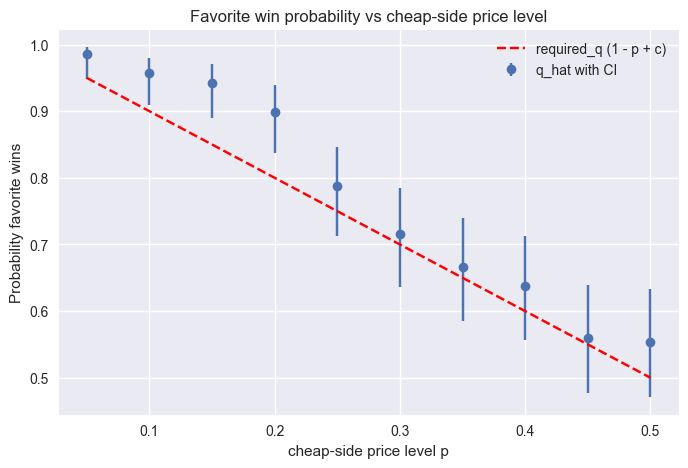

In [38]:
# Optional: visualize q_hat vs p and required_q

if not summary.empty:
    fig, ax = plt.subplots(figsize=(8, 5))

    ax.errorbar(
        summary_sorted['p_level'],
        summary_sorted['q_hat'],
        yerr=[summary_sorted['q_hat'] - summary_sorted['ci_low'],
              summary_sorted['ci_high'] - summary_sorted['q_hat']],
        fmt='o', capsize=4, label='q_hat with CI'
    )

    ax.plot(summary_sorted['p_level'], summary_sorted['required_q'],
            color='red', linestyle='--', label='required_q (1 - p + c)')

    ax.set_xlabel('cheap-side price level p')
    ax.set_ylabel('Probability favorite wins')
    ax.set_title('Favorite win probability vs cheap-side price level')
    ax.legend()
    ax.grid(True)

    plt.show()
else:
    print("Summary is empty; no events to plot.")


### 7. Visualize EV vs. price level

To complement the probability plot, it’s useful to see how **expected value** varies by cheap-side price level, while also showing how many **hits** we have at each level.

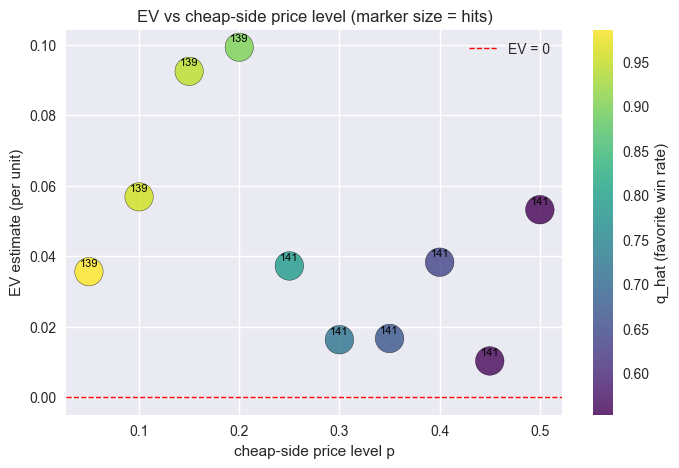

In [39]:
# EV vs price level, with hits encoded in marker size and q_hat in color

if not summary_sorted.empty:
    fig, ax = plt.subplots(figsize=(8, 5))

    sizes = summary_sorted['hits'] * 3  # scale marker sizes by sample count

    scatter = ax.scatter(
        summary_sorted['p_level'],
        summary_sorted['ev_estimate'],
        s=sizes,
        c=summary_sorted['q_hat'],
        cmap='viridis',
        alpha=0.8,
        edgecolor='k',
    )

    for _, row in summary_sorted.iterrows():
        ax.annotate(
            f"{int(row['hits'])}",
            (row['p_level'], row['ev_estimate']),
            textcoords="offset points",
            xytext=(0, 4),
            ha='center',
            fontsize=8,
            color='black',
        )

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('q_hat (favorite win rate)')

    ax.axhline(0.0, color='red', linestyle='--', linewidth=1, label='EV = 0')

    ax.set_xlabel('cheap-side price level p')
    ax.set_ylabel('EV estimate (per unit)')
    ax.set_title('EV vs cheap-side price level (marker size = hits)')
    ax.grid(True)
    ax.legend()

    plt.show()
else:
    print("Summary is empty; no EV plot to show.")


### 8. Finer-grained analysis: 1% intervals

Re-run the analysis with **1% price level intervals** from 0.50 down to 0.01 to get more granular insight into where EV peaks and how sample sizes vary across thresholds.


In [40]:
# Build event dataset with 1% intervals (0.50 down to 0.01)

# Cheap-side levels from 50% down to 1% in 1% steps
bins_1pct = np.arange(0.50, 0.00, -0.01)  # 0.50, 0.49, ..., 0.02, 0.01
print(f"Bins (1% intervals): {len(bins_1pct)} levels from {bins_1pct[0]:.2f} to {bins_1pct[-1]:.2f}")
print(f"First 5: {bins_1pct[:5]}")
print(f"Last 5: {bins_1pct[-5:]}")

# Only keep rows where we have the derived columns we need
required = ['market_id', 'ts', 'price_cheap', 'final_fav_won']
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns for event extraction: {missing}")

events_1pct = extract_price_hit_events(df, bins=bins_1pct)
print(f"\nEvents shape: {events_1pct.shape}")

events_1pct.head()


Bins (1% intervals): 50 levels from 0.50 to 0.01
First 5: [0.5  0.49 0.48 0.47 0.46]
Last 5: [0.05 0.04 0.03 0.02 0.01]

Events shape: (6996, 4)


,market_id,p_level,price_at_hit,final_fav_won
0,667567,0.50,0.500,1
1,667567,0.49,0.490,0
2,667567,0.48,0.415,0
3,667567,0.47,0.415,0
4,667567,0.46,0.415,0


In [43]:
# Summarize q(p) and EV by cheap-side level (1% intervals)

cost_buffer = 0.0  # Same cost buffer as before
summary_1pct = summarize_q_by_level(events_1pct, cost_buffer=cost_buffer, alpha=0.05)

summary_1pct_sorted = summary_1pct.sort_values('p_level', ascending=False)  # Descending: 0.50 -> 0.01
summary_1pct_sorted.sort_values("ev_estimate", ascending=False).head(20)  # Show first 20 rows (highest p_levels)


,p_level,hits,wins,q_hat,ci_low,ci_high,required_q,ev_estimate
17,0.18,139,130,0.935252,0.881528,0.965565,0.82,0.115252
16,0.17,139,131,0.942446,0.890543,0.970551,0.83,0.112446
18,0.19,139,128,0.920863,0.863851,0.955239,0.81,0.110863
20,0.21,139,125,0.899281,0.838034,0.939052,0.79,0.109281
19,0.20,139,126,0.906475,0.846559,0.944528,0.80,0.106475
15,0.16,139,131,0.942446,0.890543,0.970551,0.84,0.102446
14,0.15,139,132,0.949640,0.899702,0.975394,0.85,0.099640
13,0.14,139,131,0.942446,0.890543,0.970551,0.86,0.082446
12,0.13,139,132,0.949640,0.899702,0.975394,0.87,0.079640
22,0.23,139,118,0.848921,0.780063,0.899012,0.77,0.078921


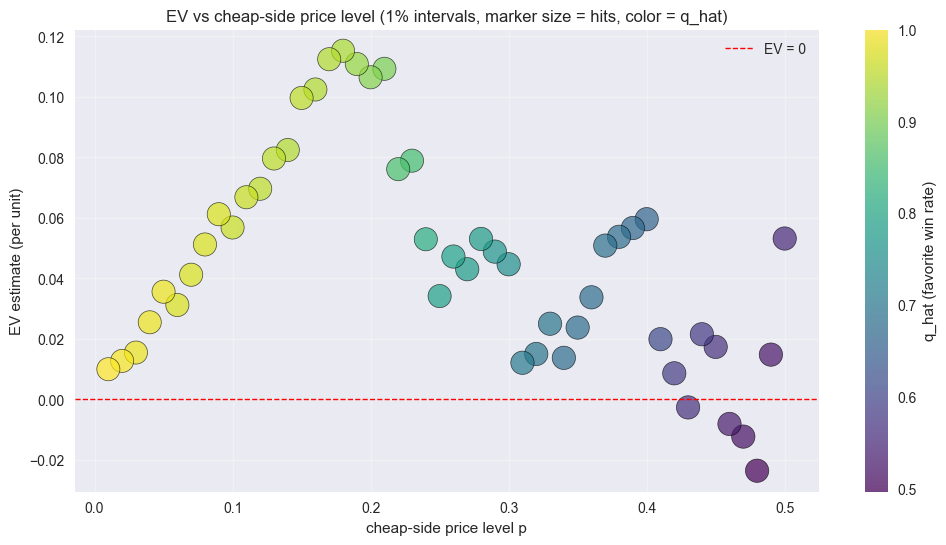

Found 16 valid thresholds (ci_low > required_q, hits >= 10):

 p_level  hits  wins    q_hat   ci_low  required_q  ev_estimate
    0.23   139   118 0.848921 0.780063        0.77     0.078921
    0.22   139   119 0.856115 0.788190        0.78     0.076115
    0.21   139   125 0.899281 0.838034        0.79     0.109281
    0.20   139   126 0.906475 0.846559        0.80     0.106475
    0.19   139   128 0.920863 0.863851        0.81     0.110863
    0.18   139   130 0.935252 0.881528        0.82     0.115252
    0.17   139   131 0.942446 0.890543        0.83     0.112446
    0.16   139   131 0.942446 0.890543        0.84     0.102446
    0.15   139   132 0.949640 0.899702        0.85     0.099640
    0.14   139   131 0.942446 0.890543        0.86     0.082446
    0.13   139   132 0.949640 0.899702        0.87     0.079640
    0.12   139   132 0.949640 0.899702        0.88     0.069640
    0.11   139   133 0.956835 0.909029        0.89     0.066835
    0.10   139   133 0.956835 0.909029    